<img src='otus.png'>

In [2]:
from __future__ import print_function
from collections import defaultdict
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm

%matplotlib inline
plt.rcParams["figure.figsize"] = (15, 8)
pd.options.display.float_format = '{:.2f}'.format

# Ансамбли моделей

### Мудрость толпы

Если спросить много людей о некоторой характеристике и усреднить - получится результат лучше, чем полученный от одного эксперта.  

В онлайне размещена картинка с коровой. Люди заходят на сайт и дают оценку ее веса. Средний результат из 17000 предсказаний отклоняется от действительного значения на 5%.

https://en.wikipedia.org/wiki/Wisdom_of_the_crowd
https://www.amazon.com/Wisdom-Crowds-James-Surowiecki/dp/0385721706

### Netflix prize

Объявлен приз в 1 млн. долларов за улучшение предсказания на 10%. После построения простых качественных моделей составляются ансамбли из моделей. Это комбинирование простых моделей в одну более сложную, делающую более качественное предсказание.

https://www.netflixprize.com/assets/GrandPrize2009_BPC_BellKor.pdf

## Voting Classifiers



In [3]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=500, noise=0.30, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

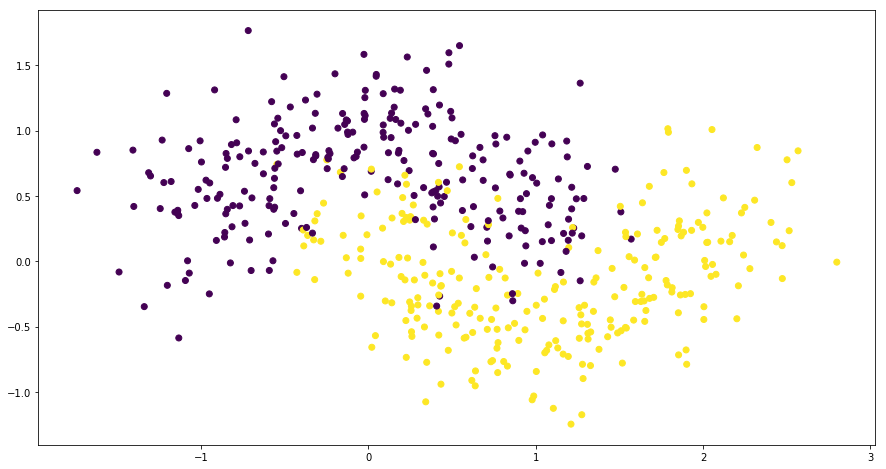

In [4]:
plt.scatter(X[:, 0], X[:, 1], c=y)

### Hard voting
Построим несколько простых моделей на одних и тех же данных.  
Предсказание будем делать всеми моделями, в результате предсказания выберем тот класс, за который проголосовало большинство моделей - **hard voting**

In [5]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

log_clf = LogisticRegression(random_state=42)
rnd_clf = RandomForestClassifier(random_state=42)
svm_clf = SVC(random_state=42)

voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='hard')
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=42, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)), ('rf', RandomFor...f',
  max_iter=-1, probability=False, random_state=42, shrinking=True,
  tol=0.001, verbose=False))],
         flatten_transform=None, n_jobs=1, voting='hard', weights=None)

In [6]:
from sklearn.metrics import accuracy_score

for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.864
RandomForestClassifier 0.872
SVC 0.888
VotingClassifier 0.896


### Soft voting
Если все классификаторы могут вернуть вероятность (реализован метод predict proba), то можем посчитать среднее - **soft voting**

In [7]:
log_clf = LogisticRegression(random_state=42)
rnd_clf = RandomForestClassifier(random_state=42)
svm_clf = SVC(probability=True, random_state=42)

voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='soft')
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=42, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)), ('rf', RandomFor...bf',
  max_iter=-1, probability=True, random_state=42, shrinking=True,
  tol=0.001, verbose=False))],
         flatten_transform=None, n_jobs=1, voting='soft', weights=None)

In [8]:
from sklearn.metrics import accuracy_score

for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.864
RandomForestClassifier 0.872
SVC 0.888
VotingClassifier 0.912


На ирисах:

In [9]:
from sklearn import datasets
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier

iris = datasets.load_iris()
X, y = iris.data[:, 1:3], iris.target

clf1 = LogisticRegression(random_state=1)
clf2 = RandomForestClassifier(random_state=1)
clf3 = GaussianNB()

eclf = VotingClassifier(estimators=[('lr', clf1), ('rf', clf2), ('gnb', clf3)], voting='hard')

for clf, label in zip([clf1, clf2, clf3, eclf], ['Logistic Regression', 'Random Forest', 'naive Bayes', 'Ensemble']):
    scores = cross_val_score(clf, X, y, cv=5, scoring='accuracy')
    print("Accuracy: %0.3f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), label))

Accuracy: 0.900 (+/- 0.05) [Logistic Regression]
Accuracy: 0.933 (+/- 0.05) [Random Forest]
Accuracy: 0.913 (+/- 0.04) [naive Bayes]
Accuracy: 0.947 (+/- 0.05) [Ensemble]


In [10]:
from sklearn import datasets
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from itertools import product
from sklearn.ensemble import VotingClassifier

# Loading some example data
iris = datasets.load_iris()
X = iris.data[:, [0,2]]
y = iris.target

# Training classifiers
clf1 = DecisionTreeClassifier(max_depth=4)
clf2 = KNeighborsClassifier(n_neighbors=7)
clf3 = SVC(kernel='rbf', probability=True)
eclf = VotingClassifier(estimators=[('dt', clf1), ('knn', clf2), ('svc', clf3)], voting='soft', weights=[2, 1, 2])

clf1 = clf1.fit(X,y)
clf2 = clf2.fit(X,y)
clf3 = clf3.fit(X,y)
eclf = eclf.fit(X,y)


for clf, label in zip([clf1, clf2, clf3, eclf], ['Logistic Regression', 'Random Forest', 'naive Bayes', 'Ensemble']):
    scores = cross_val_score(clf, X, y, cv=5, scoring='accuracy')
    print("Accuracy: %0.3f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), label))

Accuracy: 0.927 (+/- 0.07) [Logistic Regression]
Accuracy: 0.940 (+/- 0.04) [Random Forest]
Accuracy: 0.947 (+/- 0.03) [naive Bayes]
Accuracy: 0.927 (+/- 0.07) [Ensemble]


### Подбор параметров

In [11]:
from sklearn.model_selection import GridSearchCV
clf1 = LogisticRegression(random_state=1)
clf2 = RandomForestClassifier(random_state=1)
clf3 = GaussianNB()
eclf = VotingClassifier(estimators=[('lr', clf1), ('rf', clf2), ('gnb', clf3)], voting='soft')

params = {'lr__C': [1.0, 100.0], 'rf__n_estimators': [20, 200],}

grid = GridSearchCV(estimator=eclf, param_grid=params, cv=5)
grid = grid.fit(iris.data, iris.target)

In [12]:
grid.best_estimator_

VotingClassifier(estimators=[('lr', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=1, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)), ('rf', RandomFore...   oob_score=False, random_state=1, verbose=0, warm_start=False)), ('gnb', GaussianNB(priors=None))],
         flatten_transform=None, n_jobs=1, voting='soft', weights=None)

In [13]:
grid.best_score_

0.95999999999999996

# Bagging - bootstrap aggregation

Из выборки генерируем сэмпл. Сэмплирование делаем с возвращением.

In [14]:
def subsample(data, ratio=1.0):
    return np.random.choice(data, size=int(data.shape[0] * ratio), replace=True)

In [15]:
dataset = np.random.randint(0, 1000, size=10)

In [16]:
dataset

array([ 55, 503, 227, 270, 743, 133, 337, 660, 816, 367])

In [17]:
np.unique(np.bincount(dataset))

array([0, 1])

In [18]:
sample = subsample(dataset, ratio=0.4)

In [19]:
np.unique(np.bincount(sample))

array([0, 1, 2])

In [20]:
sample

array([660, 270, 367, 367])

Вычислим среднее

In [21]:
means = []
n_iterations = 10
for i in range(n_iterations):
    sample = subsample(dataset, ratio=0.4)
    mean = sample.mean()
    means.append(mean)
sum(means) / n_iterations


399.30000000000001

In [22]:
dataset.mean()

411.10000000000002

### Bagging

* Сгенерировать подвыборку с возвращением, обучить модель.  
Для обучения будем использовать один и тот же алгоритм.  
* Повторить много раз
* Для нового примера сделать предсказание и сагрегировать результат (например, вычислить моду - самое частое или среднее предсказание)

Можно обучать параллельлно

In [23]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

X, y = make_moons(n_samples=500, noise=0.30, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

bag_clf = BaggingClassifier(
    DecisionTreeClassifier(random_state=42), 
    n_estimators=500,
    max_samples=100, 
    bootstrap=True, 
    n_jobs=-1, 
    random_state=42
)
bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)

In [24]:
from sklearn.metrics import accuracy_score
print(accuracy_score(y_test, y_pred))


0.904


In [25]:
tree_clf = DecisionTreeClassifier(random_state=42)
tree_clf.fit(X_train, y_train)
y_pred_tree = tree_clf.predict(X_test)
print(accuracy_score(y_test, y_pred_tree))

0.856


In [26]:
from matplotlib.colors import ListedColormap

def plot_decision_boundary(clf, X, y, axes=[-1.5, 2.5, -1, 1.5], alpha=0.5, contour=True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    if contour:
        custom_cmap2 = ListedColormap(['#7d7d58','#4c4c7f','#507d50'])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", alpha=alpha)
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", alpha=alpha)
    plt.axis(axes)
    plt.xlabel(r"$x_1$", fontsize=18)
    plt.ylabel(r"$x_2$", fontsize=18, rotation=0)

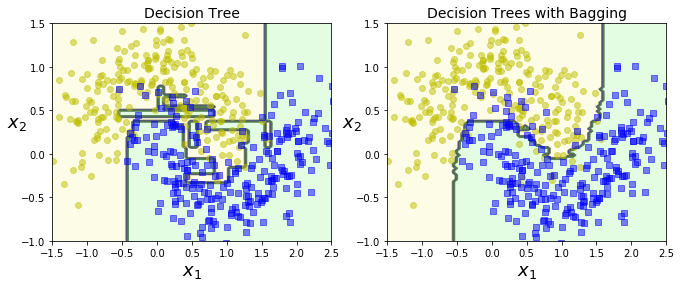

In [27]:
plt.figure(figsize=(11,4))
plt.subplot(121)
plot_decision_boundary(tree_clf, X, y)
plt.title("Decision Tree", fontsize=14)
plt.subplot(122)
plot_decision_boundary(bag_clf, X, y)
plt.title("Decision Trees with Bagging", fontsize=14)
plt.show()

| idx | a | b | c |
|---|---|---|---|
|1   | 0.1  | 0.01  | 10  |
|2  | 0.2  | 0.02  |  20 |
|3   |  0.3 | 0.03  | 30  |
|4   |  0.4 |  0.04 | 40  |

| idx | a | b | c |
|---|---|---|---|
|1   | 0.1  | 0.01  | 10  |
|4   |  0.4 |  0.04 | 40  |

| idx | a | b | c |
|---|---|---|---|
|1   | 0.1  | 0.01  | 10  |
|1   | 0.1  | 0.01  | 10  |


| idx | a | b | c |
|---|---|---|---|
|1   | 0.1  | 0.01  | 10  |
|2  | 0.2  | 0.02  |  20 |


| idx | a | b | c |
|---|---|---|---|
|1   | 0.1  | 0.01  | 10  |
|3   |  0.3 | 0.03  | 30  |


## Random subspace method

Брать случайные признаки

| idx | a | b | c |
|---|---|---|---|
|1   | 0.1  | 0.01  | 10  |
|2  | 0.2  | 0.02  |  20 |
|3   |  0.3 | 0.03  | 30  |
|4   |  0.4 |  0.04 | 40  |

| idx | a |c |
|---|---|---|
|1   | 0.1  |10  |
|2  | 0.2  | 20 |
|3   |  0.3 | 30  |
|4   |  0.4 | 40  |

| idx | a | b | 
|---|---|---|
|1   | 0.1  | 0.01  |
|2  | 0.2  | 0.02  |
|3   |  0.3 | 0.03  |
|4   |  0.4 |  0.04 |

* bootstrap=False
* max_samples=1.0
* bootstrap_features=True
* max_features < 1.0

## Random Patches method

Брать случайные признаки и случайные примеры

* bootstrap=True
* max_samples= < 1.0
* bootstrap_features=True
* max_features < 1.0

| idx | a | b | c |
|---|---|---|---|
|1   | 0.1  | 0.01  | 10  |
|2  | 0.2  | 0.02  |  20 |
|3   |  0.3 | 0.03  | 30  |
|4   |  0.4 |  0.04 | 40  |

| idx | a |c |
|---|---|---|
|2  | 0.2  | 20 |
|4   |  0.4 | 40  |

| idx | a | b | 
|---|---|---|
|2  | 0.2  | 0.02  |
|3   |  0.3 | 0.03  |


# Random forest
* descision tree
* bagging


In [28]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(splitter="random", max_leaf_nodes=16, random_state=42),
    n_estimators=500, max_samples=1.0, bootstrap=True, n_jobs=-1, random_state=42)

In [29]:
bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)

In [30]:
from sklearn.ensemble import RandomForestClassifier

rnd_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16, n_jobs=-1, random_state=42)
rnd_clf.fit(X_train, y_train)

y_pred_rf = rnd_clf.predict(X_test)

In [31]:
np.sum(y_pred == y_pred_rf) * 1. / len(y_pred)  # almost identical predictions

0.97599999999999998

In [32]:
from sklearn.datasets import load_iris
iris = load_iris()
rnd_clf = RandomForestClassifier(n_estimators=500, n_jobs=-1, random_state=42)
rnd_clf.fit(iris["data"], iris["target"])
for name, score in zip(iris["feature_names"], rnd_clf.feature_importances_):
    print(name, score)

sepal length (cm) 0.112492250999
sepal width (cm) 0.0231192882825
petal length (cm) 0.441030464364
petal width (cm) 0.423357996355


In [33]:
rnd_clf.feature_importances_

array([ 0.11249225,  0.02311929,  0.44103046,  0.423358  ])

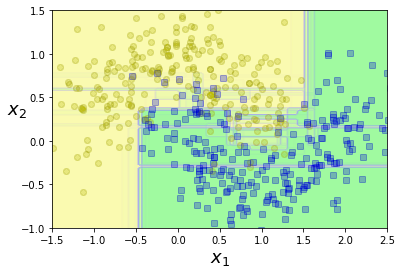

In [34]:
plt.figure(figsize=(6, 4))

for i in range(15):
    tree_clf = DecisionTreeClassifier(max_leaf_nodes=16, random_state=42 + i)
    indices_with_replacement = np.random.randint(0, len(X_train), len(X_train))
    tree_clf.fit(X[indices_with_replacement], y[indices_with_replacement])
    plot_decision_boundary(tree_clf, X, y, axes=[-1.5, 2.5, -1, 1.5], alpha=0.02, contour=False)

plt.show()

## Важность признаков

In [35]:
from sklearn.datasets import fetch_mldata
mnist = fetch_mldata('MNIST original')

In [36]:
rnd_clf = RandomForestClassifier(random_state=42)
rnd_clf.fit(mnist["data"], mnist["target"])

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [37]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = matplotlib.cm.hot,
               interpolation="nearest")
    plt.axis("off")

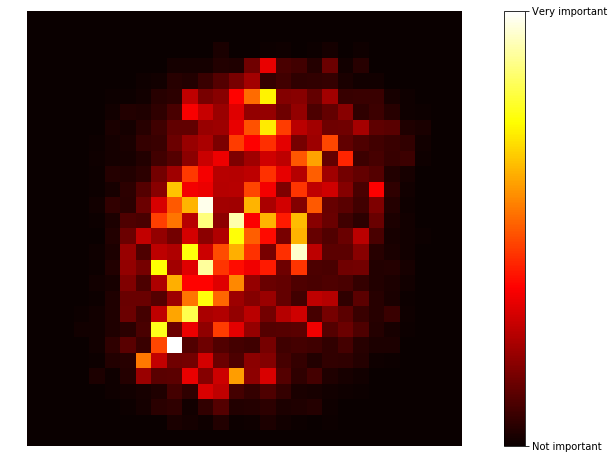

In [38]:
plot_digit(rnd_clf.feature_importances_)
cbar = plt.colorbar(ticks=[rnd_clf.feature_importances_.min(), rnd_clf.feature_importances_.max()])
cbar.ax.set_yticklabels(['Not important', 'Very important'])
plt.show()

# Extremely Randomized Trees

Случайным образом выбирать порог для разбиения

In [39]:
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier

X, y = make_moons(n_samples=500, noise=0.30, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

rnd_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16, n_jobs=-1, random_state=42)
rnd_clf.fit(X_train, y_train)

y_pred_rf = rnd_clf.predict(X_test)
print(accuracy_score(y_test, y_pred_rf))

ex_clf = ExtraTreesClassifier(n_estimators=500, max_leaf_nodes=16, n_jobs=-1, random_state=42)
ex_clf.fit(X_train, y_train)

y_pred_ex = ex_clf.predict(X_test)
print(accuracy_score(y_test, y_pred_ex))

0.912
0.912


# Boosting

* Обучить модель
* Посчитать ошибки
* Учесть ошибки и обучить новую модель
* Повторять некоторое количество раз

Нельзя обучать параллельно

# AdaBoost
Будем влиять на вес тренировочных примеров, участвующих в обучении.  
Из этих весов сможем рассчитывать вес модели

In [40]:
from sklearn.ensemble import AdaBoostClassifier

ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1), n_estimators=200,
    algorithm="SAMME.R", learning_rate=0.5, random_state=42)
ada_clf.fit(X_train, y_train)

AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=1,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
          learning_rate=0.5, n_estimators=200, random_state=42)

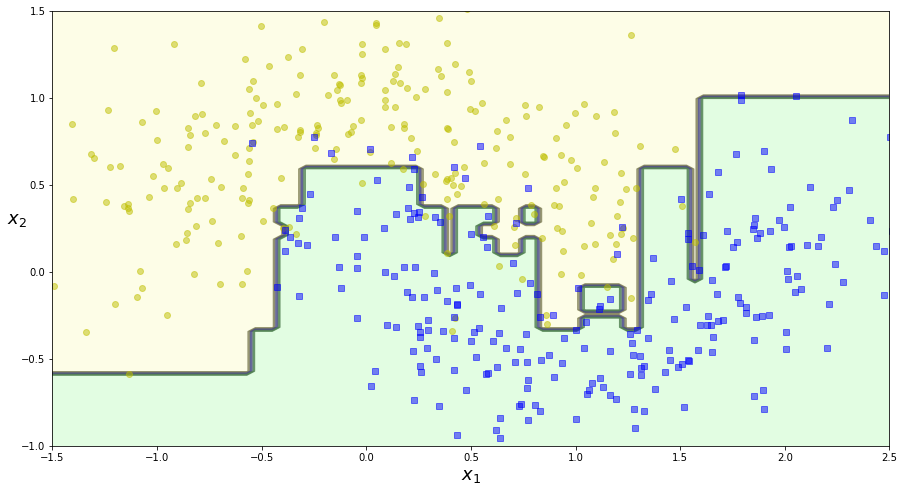

In [41]:
plot_decision_boundary(ada_clf, X, y)


Веса $w_i$ каждого обучающего примера $X_i$
$$X = \begin{bmatrix} 
a_1 & b_1 & c_1 & ... \\ 
a_2 & b_2 & c_2 & ... \\ 
a_3 & b_3 & c_3 & ... \\
... & ... & ... & ...
\end{bmatrix}, \space 
w = \begin{bmatrix} 
w_1 \\ 
w_2 \\ 
w_3 \\
... 
\end{bmatrix}$$

initially

$$w_i = \frac{1}{m}$$


$m$ - количество примеров в обучающей выборке (количество строк в $X$)

Обучаем модель и считаем ее error rate:


$$r = \frac{\sum\limits_{\hat{y} \neq y}{w}}{\sum w}$$

Чем больше ошибок, тем больше $r$

Считаем вес модели:

$$ \alpha = \eta log \frac{1-r}{r} $$

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:2: RuntimeWarning: divide by zero encountered in divide
  from ipykernel import kernelapp as app
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:2: RuntimeWarning: invalid value encountered in log
  from ipykernel import kernelapp as app


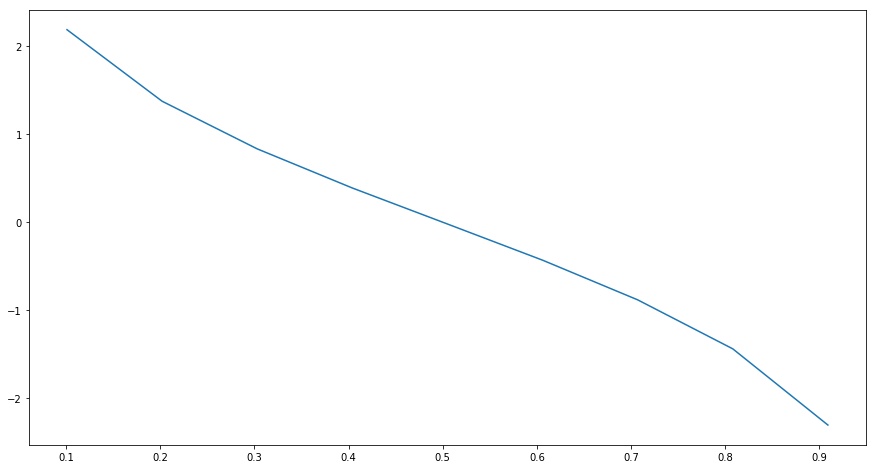

In [42]:
def f(x):
    return np.log((1 - x) / x)

x = np.linspace(0, 10, 100)
y = f(x)
plt.plot(x, y)

Обновим веса:

$w$ не меняется, если предсказание верное   
$w \leftarrow w \cdot e^{\alpha} $, если предсказание ошибочное

Все веса нормализуются, делятся на $\sum w$

# Gradient Boosting

In [43]:
np.random.seed(42)
X = np.random.rand(100, 1) - 0.5
y = 3 * X[:, 0] ** 2 + 0.05 * np.random.randn(100)

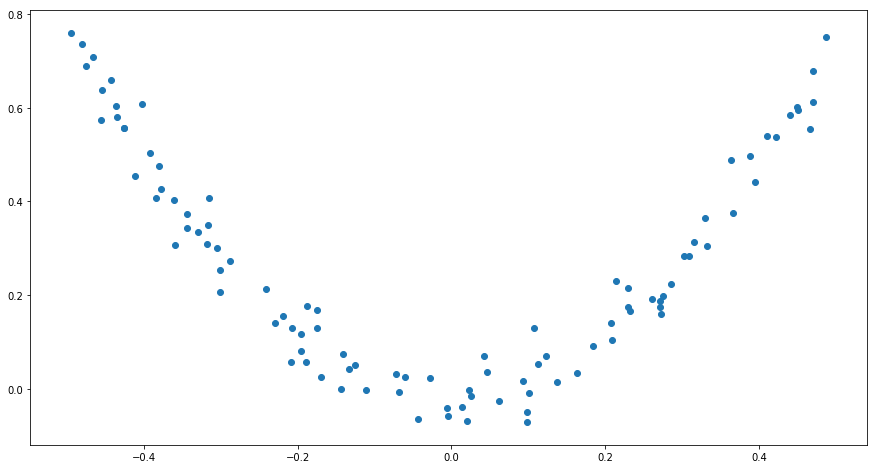

In [44]:
plt.scatter(X, y)

In [45]:

from sklearn.tree import DecisionTreeRegressor

tree_reg1 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg1.fit(X, y)

DecisionTreeRegressor(criterion='mse', max_depth=2, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=42, splitter='best')

In [46]:
y2 = y - tree_reg1.predict(X)
tree_reg2 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg2.fit(X, y2)

DecisionTreeRegressor(criterion='mse', max_depth=2, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=42, splitter='best')

In [47]:
y3 = y2 - tree_reg2.predict(X)
tree_reg3 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg3.fit(X, y3)

DecisionTreeRegressor(criterion='mse', max_depth=2, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=42, splitter='best')

In [48]:
X_new = np.array([[0.8]])

In [49]:
y_pred = sum(tree.predict(X_new) for tree in (tree_reg1, tree_reg2, tree_reg3))

In [50]:
y_pred

array([ 0.75026781])

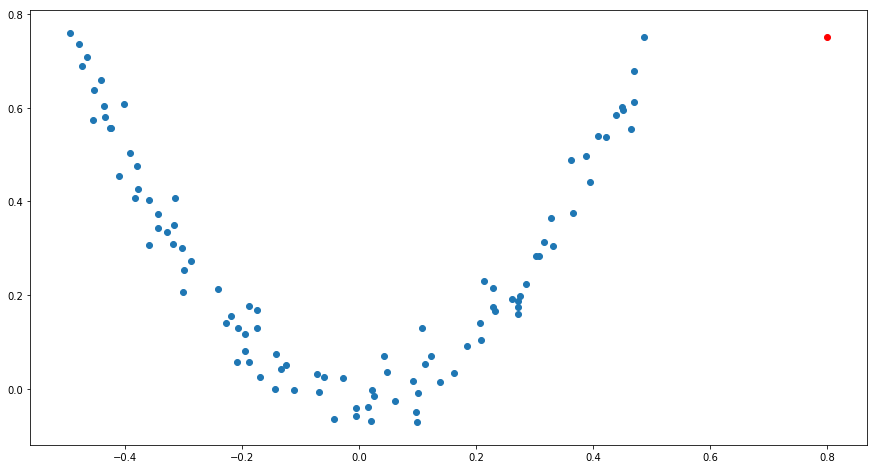

In [51]:
plt.scatter(X, y)
plt.scatter(X_new, y_pred, c='red')

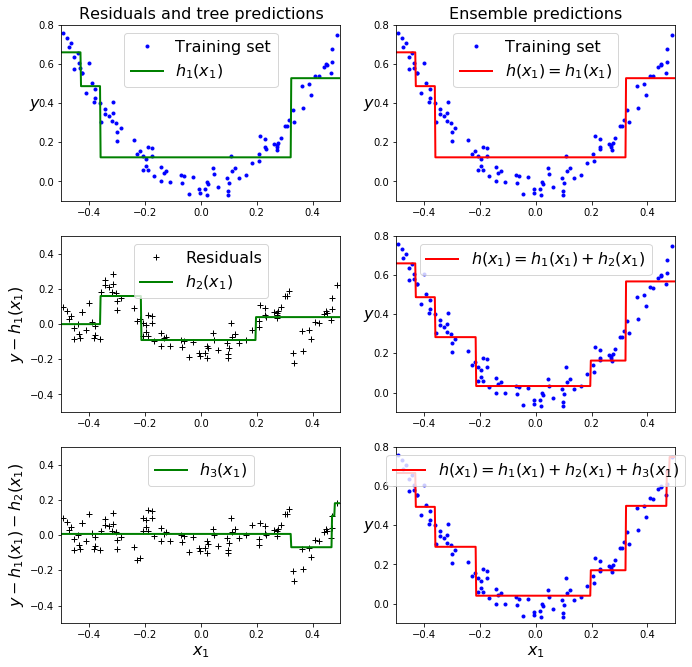

In [52]:
def plot_predictions(regressors, X, y, axes, label=None, style="r-", data_style="b.", data_label=None):
    x1 = np.linspace(axes[0], axes[1], 500)
    y_pred = sum(regressor.predict(x1.reshape(-1, 1)) for regressor in regressors)
    plt.plot(X[:, 0], y, data_style, label=data_label)
    plt.plot(x1, y_pred, style, linewidth=2, label=label)
    if label or data_label:
        plt.legend(loc="upper center", fontsize=16)
    plt.axis(axes)

plt.figure(figsize=(11,11))

plt.subplot(321)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h_1(x_1)$", style="g-", data_label="Training set")
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.title("Residuals and tree predictions", fontsize=16)

plt.subplot(322)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1)$", data_label="Training set")
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.title("Ensemble predictions", fontsize=16)

plt.subplot(323)
plot_predictions([tree_reg2], X, y2, axes=[-0.5, 0.5, -0.5, 0.5], label="$h_2(x_1)$", style="g-", data_style="k+", data_label="Residuals")
plt.ylabel("$y - h_1(x_1)$", fontsize=16)

plt.subplot(324)
plot_predictions([tree_reg1, tree_reg2], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1) + h_2(x_1)$")
plt.ylabel("$y$", fontsize=16, rotation=0)

plt.subplot(325)
plot_predictions([tree_reg3], X, y3, axes=[-0.5, 0.5, -0.5, 0.5], label="$h_3(x_1)$", style="g-", data_style="k+")
plt.ylabel("$y - h_1(x_1) - h_2(x_1)$", fontsize=16)
plt.xlabel("$x_1$", fontsize=16)

plt.subplot(326)
plot_predictions([tree_reg1, tree_reg2, tree_reg3], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1) + h_2(x_1) + h_3(x_1)$")
plt.xlabel("$x_1$", fontsize=16)
plt.ylabel("$y$", fontsize=16, rotation=0)

plt.show()

## Недообучение и переобучение


In [53]:
from sklearn.ensemble import GradientBoostingRegressor

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=3, learning_rate=1.0, random_state=42)
gbrt.fit(X, y)


gbrt_slow = GradientBoostingRegressor(max_depth=2, n_estimators=200, learning_rate=0.1, random_state=42)
gbrt_slow.fit(X, y)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=2, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=200, presort='auto', random_state=42,
             subsample=1.0, verbose=0, warm_start=False)

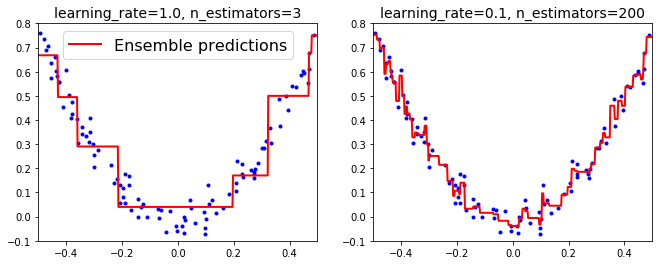

In [54]:
plt.figure(figsize=(11,4))

plt.subplot(121)
plot_predictions([gbrt], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="Ensemble predictions")
plt.title("learning_rate={}, n_estimators={}".format(gbrt.learning_rate, gbrt.n_estimators), fontsize=14)

plt.subplot(122)
plot_predictions([gbrt_slow], X, y, axes=[-0.5, 0.5, -0.1, 0.8])
plt.title("learning_rate={}, n_estimators={}".format(gbrt_slow.learning_rate, gbrt_slow.n_estimators), fontsize=14)

plt.show()

In [55]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=49)

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=120, random_state=42)
gbrt.fit(X_train, y_train)

errors = [mean_squared_error(y_val, y_pred)
          for y_pred in gbrt.staged_predict(X_val)]
bst_n_estimators = np.argmin(errors)

gbrt_best = GradientBoostingRegressor(max_depth=2,n_estimators=bst_n_estimators, random_state=42)
gbrt_best.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=2, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=55, presort='auto', random_state=42,
             subsample=1.0, verbose=0, warm_start=False)

In [56]:
min_error = np.min(errors)


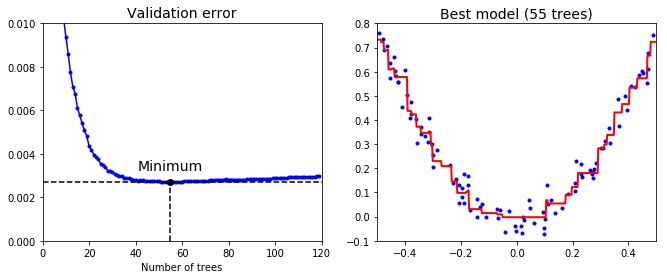

In [57]:
plt.figure(figsize=(11, 4))

plt.subplot(121)
plt.plot(errors, "b.-")
plt.plot([bst_n_estimators, bst_n_estimators], [0, min_error], "k--")
plt.plot([0, 120], [min_error, min_error], "k--")
plt.plot(bst_n_estimators, min_error, "ko")
plt.text(bst_n_estimators, min_error*1.2, "Minimum", ha="center", fontsize=14)
plt.axis([0, 120, 0, 0.01])
plt.xlabel("Number of trees")
plt.title("Validation error", fontsize=14)

plt.subplot(122)
plot_predictions([gbrt_best], X, y, axes=[-0.5, 0.5, -0.1, 0.8])
plt.title("Best model (%d trees)" % bst_n_estimators, fontsize=14)

plt.show()

# Stacking, blending

In [58]:
X, y = make_moons(n_samples=500, noise=0.30, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [59]:
log_clf = LogisticRegression(random_state=42)
rnd_clf = RandomForestClassifier(random_state=42)
svm_clf = SVC(random_state=42)

X_in, X_out, y_in, y_out = train_test_split(X_train, y_train, random_state=42) # hold-out - blending. 
# if cross_validation - out of fold - stacking

In [60]:
svm_clf.fit(X_in, y_in)
rnd_clf.fit(X_in, y_in)

svm_y = svm_clf.predict(X_out)
rnd_y = rnd_clf.predict(X_out)

In [61]:
log_clf.fit(np.c_[svm_y, rnd_y], y_out)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=42, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [62]:
y_stack = log_clf.predict(np.c_[svm_clf.predict(X_test), rnd_clf.predict(X_test)])

In [63]:
accuracy_score(y_test, y_stack)

0.86399999999999999

https://www.kaggle.com/general/18793  
https://github.com/viisar/brew

# MNIST

In [64]:
X, y = mnist["data"], mnist["target"]
X.shape

(70000, 784)

In [65]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=30000)
X_train.shape

(40000, 784)

In [66]:
X_validation, X_test, y_validation, y_test = train_test_split(X_test, y_test, random_state=42, test_size=15000)
X_validation.shape, X_test.shape

((15000, 784), (15000, 784))

In [67]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier()
sgd_clf.fit(X_train, y_train)

/usr/local/lib/python2.7/dist-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=None, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=None,
       shuffle=True, tol=None, verbose=0, warm_start=False)

In [68]:
sgd_y = sgd_clf.predict(X_test)
accuracy_score(sgd_y, y_test)

0.87326666666666664

In [ ]:
rf_clf = RandomForestClassifier()
rf_clf.fit(X_train, y_train)
rf_y = rf_clf.predict(X_test)
accuracy_score(rf_y, y_test)

0.94279999999999997

In [ ]:
rnd_clf = RandomForestClassifier(random_state=42)
svm_clf = SVC(probability=True, random_state=42)
sgd_clf = SGDClassifier()

voting_clf = VotingClassifier(
    estimators=[('rf', rnd_clf), ('svc', svm_clf), ('sgd', sgd_clf)],
    voting='soft')
voting_clf.fit(X_train, y_train)
v_y = voting_clf.predict(X_test)
accuracy_score(v_y, y_test)